In [1]:
# working to read in the trimmed produce data, and then split it into training and testing sets
# splitting is done using a walk-forward method with a windowed test set of 3 years data incremented in 3 month blocks
# training is always 3 years, test is always 3 months in advance
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

data_dir = './trimmed_data_and_plots/'

In [2]:
def generate_predict_start_dates(start_date, end_date, train_length, test_length, window_step):
    train_time = pd.to_timedelta(pd.np.ceil(train_length), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(test_length), unit="D")
    window_time = pd.to_timedelta(pd.np.ceil(window_step), unit='D')
    
    output_dates = [pd.to_datetime(start_date) + train_time]
    most_recent_date = pd.to_datetime(start_date) + train_time
    while most_recent_date + train_time + test_time <= pd.to_datetime(end_date):
        output_dates.append(most_recent_date + window_time)
        most_recent_date = most_recent_date + window_time
    return(output_dates)

In [3]:
def read_trimmed_data(city, veggie):
    # reads in cleaned .csv data for one city and veggie, returns
    output_data = pd.read_csv(data_dir+veggie+'_'+city+'_TRIM.csv')
    output_data['Date'] = pd.to_datetime(output_data['Date'])
    output_data = output_data.sort_values(by='Date')
    output_data = output_data.reset_index(drop=True)
    return output_data

In [4]:
def nearest_date(dates, targdate):
    for i in dates:
        i = i.to_pydatetime()
    nearest = min(dates, key=lambda x: abs(x - targdate))
    timedelta = abs(nearest - targdate)
    return nearest, timedelta

In [5]:
def get_train_test(veggie_data, start_date, train_days, predict_days):
    all_dates = pd.to_datetime(veggie_data['Date'])
    train_time = pd.to_timedelta(pd.np.ceil(train_days), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(predict_days), unit="D")
    start_date_train = start_date - train_time
    nearest_date_train, deltatrain = nearest_date(all_dates, start_date_train)
    end_date_test = start_date + test_time
    nearest_date_test, deltatest = nearest_date(all_dates, end_date_test)
    training_set = veggie_data[(veggie_data['Date'] >= nearest_date_train) & (veggie_data['Date'] < start_date)]
    test_set = veggie_data[(veggie_data['Date'] >= start_date) & (veggie_data['Date'] <= nearest_date_test)]
    return(training_set, test_set)

In [6]:
def naive_historical_average(veggie_data, start_dates, train_days, predict_days):
    train_time = pd.to_timedelta(pd.np.ceil(train_days), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(predict_days), unit="D")
    one_year = pd.to_timedelta(pd.np.ceil(365), unit='D')
    # first compute the historical average values
    predictions = []
    actuals = []
    for i in start_dates:
        current_train_data, current_test_data = get_train_test(veggie_data, i, train_days, predict_days)
        # at some point i'll want to make this more intelligent and handle missing data
        actuals.append(current_test_data['Average Price'].mean())
        # now do the naive historical average model
        num_years = train_days // 365
        historical_medians = []
        for y in range(num_years):
            historical_data = veggie_data[(veggie_data['Date'] >= (i-(y+1)*one_year)) & (veggie_data['Date'] <= (i-(y+1)*one_year + test_time))]
            historical_medians.append(historical_data['Average Price'].mean())
        predictions.append(pd.Series(historical_medians).mean())
    return predictions, actuals


In [7]:
def naive_current_price(veggie_data, start_dates, train_days, predict_days):
    train_time = pd.to_timedelta(pd.np.ceil(train_days), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(predict_days), unit="D")
    predictions = []
    actuals = []
    for i in start_dates:
        current_train_data, current_test_data = get_train_test(veggie_data, i, train_days, predict_days)
        # at some point i'll want to make this more intelligent and handle missing data
        actuals.append(current_test_data['Average Price'].mean())
        # now do the naive model that is just the current price
        pred = current_train_data['Average Price'].tail(10)
        predictions.append(pred.mean())
    return predictions, actuals

In [8]:
def plot_pct_misses(miss_array, city, title):
    # plot barchart of percent misses
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    
    xpos = np.arange(len(miss_array['Item']))                
    plot = plt.bar(xpos, miss_array['PCT Miss'])
    plt.xticks(xpos, miss_array['Item'])
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('PCT Miss', fontsize=14)
    plt.title(title+'_'+city)

    plt.savefig(title+'_'+city+'_pctmiss.png', format='png', bbox_inches='tight')

In [9]:
# define some variables
cities = ['NEW+YORK', 'LOS+ANGELES']
veggies = ['APPLES','APRICOTS','ASPARAGUS','AVOCADOS','BANANAS','BEANS','BEETS','BLACKBERRIES','BLUEBERRIES','BROCCOLI','BRUSSELS+SPROUTS','CABBAGE','CANTALOUPS','CARROTS','CAULIFLOWER','CELERY','CHERRIES','CLEMENTINES', 'CUCUMBERS','ENDIVE','GARLIC','GINGER+ROOT','GRAPEFRUIT','GRAPES','HONEYDEWS','KIWIFRUIT','LEMONS','LETTUCE%2C+ICEBERG','LETTUCE%2C+ROMAINE','LETTUCE%2C+RED+LEAF','LETTUCE%2C+GREEN+LEAF', 'LIMES','MANGOES','NECTARINES','OKRA','ORANGES','PEACHES','PEARS','PEAS+GREEN','PEPPERS%2C+BELL+TYPE','PINEAPPLES','PLUMS','POTATOES','RADISHES','RASPBERRIES','RHUBARB','SPINACH','SQUASH','STRAWBERRIES','TURNIPS']

#cities = ['NEW+YORK']
#veggies = ['CARROTS']

master_start_date = '20070601'
master_end_date = '20170531'
# three year train, 3 month test
train_length = 365*3
predict_length = 90
# increment window of train/test before generating new set
increment_test = 115

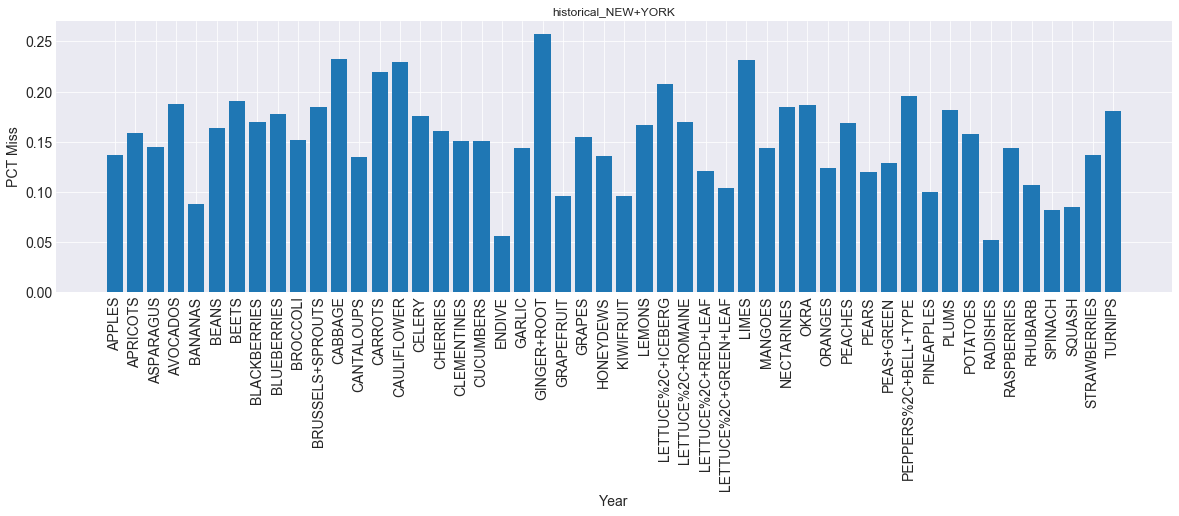

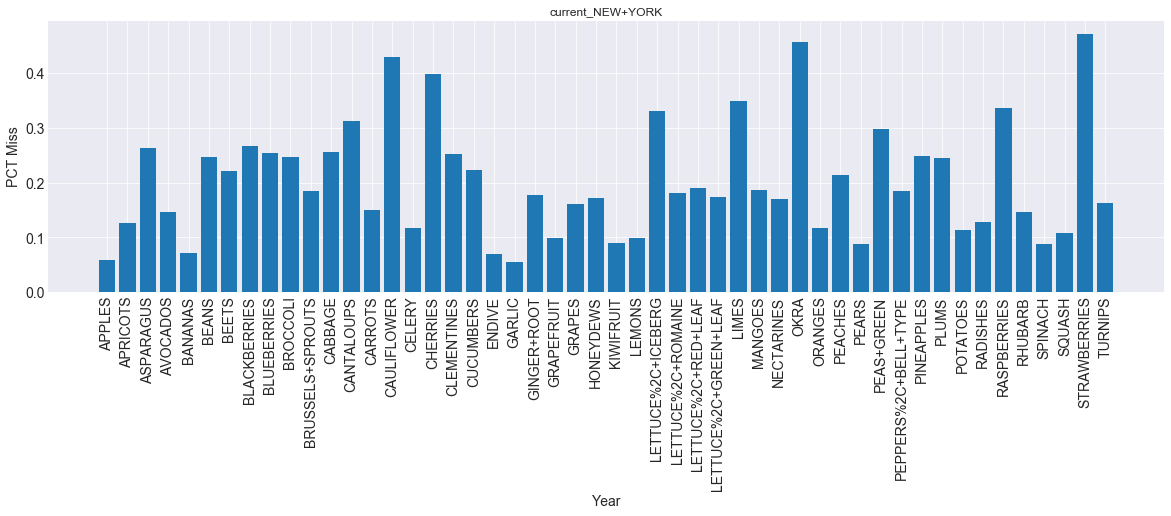

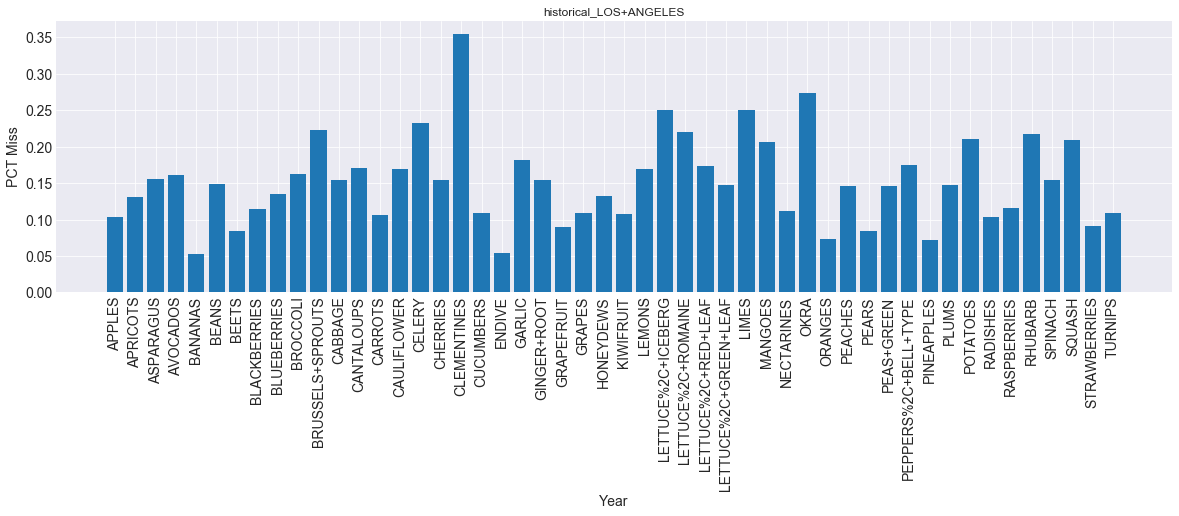

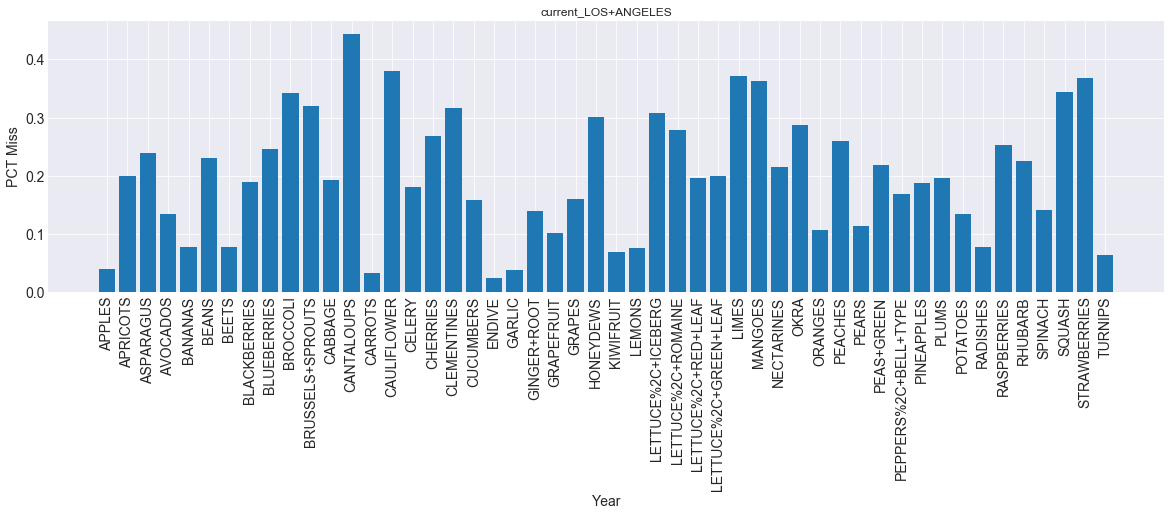

In [10]:
datelist = generate_predict_start_dates(master_start_date, master_end_date, train_length, predict_length, increment_test)

labels = ['Item', 'PCT Miss']

for c in cities:
    
    output_naive_hist = pd.DataFrame(datelist).rename(index=int, columns={0: "Date"})
    overall_stats_naive_hist = []
    
    output_naive_current = pd.DataFrame(datelist).rename(index=int, columns={0: "Date"})
    overall_stats_naive_current = []
    
    for v in veggies:
        current_veggie = read_trimmed_data(c, v)
        
        pred, act = naive_historical_average(current_veggie, datelist, train_length, predict_length)
        output_naive_hist = pd.concat([output_naive_hist, pd.Series(pred).rename(v+'_PRED'), pd.Series(act).rename(v+'_ACT')], axis=1)
        try:
            pct_miss = abs((output_naive_hist[v + '_ACT'] - output_naive_hist[v + '_PRED'])/output_naive_hist[v + '_ACT']).mean()
        except TypeError:
            pct_miss = 0.0
        overall_stats_naive_hist.append((v, pct_miss))
        
        pred, act = naive_current_price(current_veggie, datelist, train_length, predict_length)
        output_naive_current = pd.concat([output_naive_current, pd.Series(pred).rename(v+'_PRED'), pd.Series(act).rename(v+'_ACT')], axis=1)
        try:
            pct_miss = abs((output_naive_current[v + '_ACT'] - output_naive_current[v + '_PRED'])/output_naive_current[v + '_ACT']).mean()
        except TypeError:
            pct_miss = 0.0
        overall_stats_naive_current.append((v, pct_miss))
    
    summary_naive_hist = pd.DataFrame.from_records(overall_stats_naive_hist, columns=labels)
    summary_naive_hist.to_csv(c + '_naive_hist_output.csv')
    plot_pct_misses(summary_naive_hist, c, 'historical')
    
    summary_naive_current = pd.DataFrame.from_records(overall_stats_naive_current, columns=labels)
    summary_naive_current.to_csv(c + '_naive_current_output.csv')
    plot_pct_misses(summary_naive_current, c, 'current')